### I feel like I have had to re-teach myself exactly how FLASH handles ion species, charges, and densities over and over, so this should hopefully put an end to that.

### FLASH defines a **mean molecular weight** in each cell to be the inverse of the field $Y_i$ and the **average electron number per baryon** to be $Y_e$
 
$$
\text{sumy} = \sum{Y_i},
$$
$$
\text{ye} = Y_e,
$$
$$
\text{abar} = \bar{A} = \frac{1}{\sum{Y_i}},
$$
$$
\text{zbar} = \bar{Z} = Y_e \bar{A}
$$

### Let's take this in context. Start by loading in the relevant dataset

In [1]:
import yt
yt.enable_plugins() # This script uses my plugin for yt. If you don't have it, just use yt.load() instead of yt.load_for_osiris().

plot_path = "/home/dschneidinger/shared/simulations/FLASH_MagShockZ3D-Trantham_11-2024/MagShockZ_hdf5_chk_0006"
# plot_path = "/home/dschneidinger/shared/data/VAC_DEREK3D_20um/MagShockZ_hdf5_chk_0010"

try:
    ds = yt.load_for_osiris(plot_path, B_background=75000, rqm_factor = 1)
except:
    ds = yt.load(plot_path)

level = 0
dims = ds.domain_dimensions * ds.refine_by**level
all_data = ds.covering_grid(
    level,
    left_edge=ds.domain_left_edge,
    dims=dims,
)

yt : [INFO     ] 2025-07-14 13:55:45,474 Loading plugins from /home/dschneidinger/.config/yt/my_plugins.py
yt : [INFO     ] 2025-07-14 13:55:46,644 Parameters: current_time              = 4.157630190965378e-09
yt : [INFO     ] 2025-07-14 13:55:46,645 Parameters: domain_dimensions         = [384 496 384]
yt : [INFO     ] 2025-07-14 13:55:46,645 Parameters: domain_left_edge          = [-0.8   -0.075 -0.8  ]
yt : [INFO     ] 2025-07-14 13:55:46,645 Parameters: domain_right_edge         = [0.8 2.  0.8]
yt : [INFO     ] 2025-07-14 13:55:46,646 Parameters: cosmological_simulation   = 0


Channel rqm: 1835


### Let's look at abar and zbar for this dataset and make sure that it makes sense

Text(0.5, 1.0, 'abar')

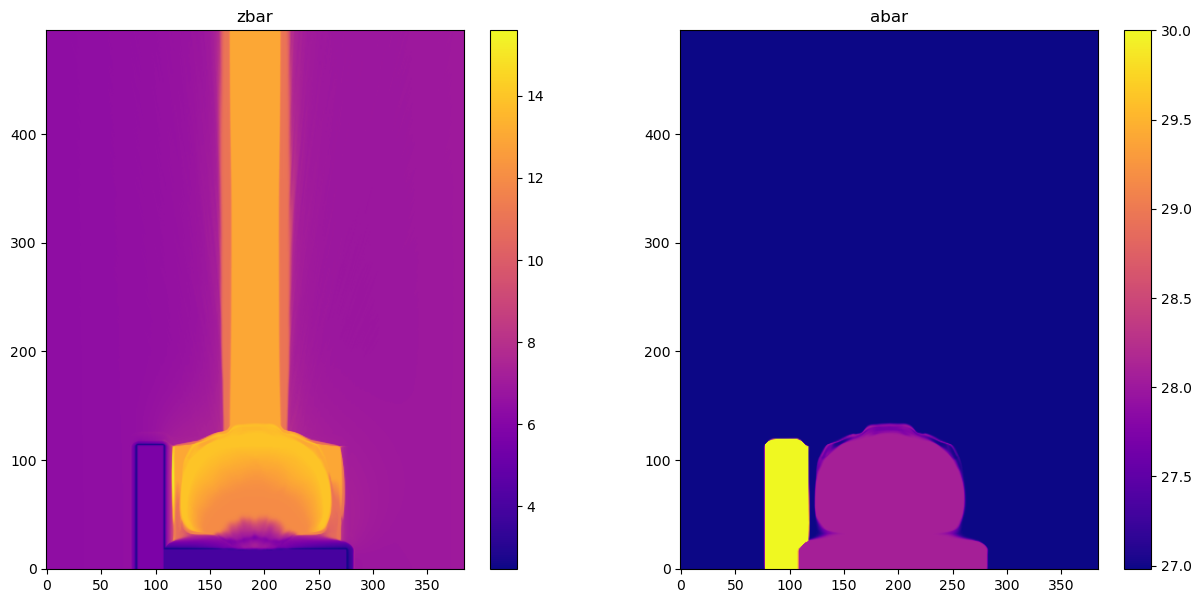

In [2]:
import matplotlib.pyplot as plt
import numpy as np
abar = 1/all_data["flash",'sumy']
zbar = all_data["flash",'ye']/all_data["flash","sumy"]

plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(zbar[:, :, np.shape(zbar)[2] // 2].T, cmap='plasma', origin='lower')
plt.colorbar()
plt.title("zbar")

plt.subplot(122)
plt.imshow(abar[:, :, np.shape(abar)[2] // 2].T, cmap='plasma', origin='lower', vmax = 30)
plt.colorbar()
plt.title("abar")

### Evidently, the charge state of the aluminum is around 6 in the background, and around 13 in the laser channel.
### Just by looking at the mean molecular weight, it looks like values are normalized to the mass of a hydrogen atom. In order to get an RQM (reciprocal charge over mass ratio) that is useful to OSIRIS, we need to get RQM $(Z/M_i)$ in units of electron charge over electron mass.
### The left plot is effectively average charge in units of electron charge, and the right plot is average mass in units of proton mass.

$$
\bar{A} = \frac{1836}{\sum{Y_i}} [m_e],\newline
\bar{Z} = Y_e \bar{A} = \frac{Y_e}{\sum{Y_i}}, \newline
\frac{\bar{A}}{\bar{Z}} = {1836}/{Y_e}
$$

### Seems simple enough.

We can actually use the value of abar to create a mask for ion species. We will end up using a similar technique later but let's just run it now

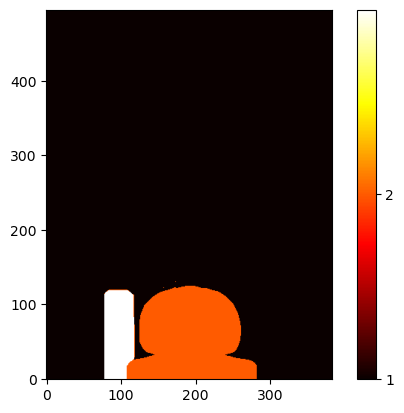

In [3]:
thresholds = [28,35]  # Define thresholds to delineate one ion species from another
bins = [-np.inf] + thresholds + [np.inf]
species_mask = np.digitize(abar, bins)

plt.imshow(species_mask[:, :, np.shape(abar)[2] // 2].T, cmap='hot', origin='lower')
plt.colorbar(ticks=range(len(thresholds)+1))

### Looks good. Using this, we can clearly see that where the three ion poulations are located in the simulation. The background is aluminum, the target is silicon, and the x-ray shield is stainless steel. Not sure if there is a more generalized way to do this. I think that you need to just have prior knowledge about how the FLASH simulation was set up.
Moving on...

Text(0.5, 1.0, 'Also Real RQM but with a lower colorbar limit')

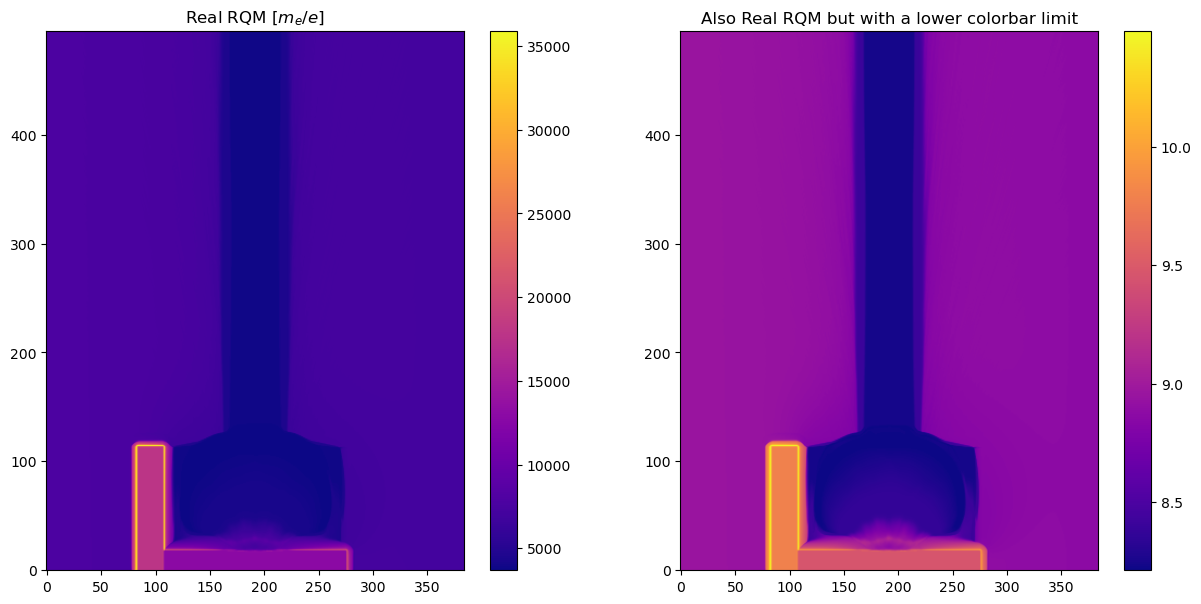

In [4]:
rqm_real = 1836/all_data["flash","ye"]

plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(rqm_real[:, :, np.shape(zbar)[2] // 2].T, cmap='plasma', origin='lower')
plt.colorbar()
plt.title(r"Real RQM $[m_e/e]$")

plt.subplot(122)
plt.imshow(np.log(rqm_real[:, :, np.shape(abar)[2] // 2].T), cmap='plasma', origin='lower')
plt.colorbar()
plt.title("Also Real RQM but with a lower colorbar limit")

It looks about right. The stainless steel shield is largely solid at very low ionization states, so we would expect an extremely large value for that. The weakly ionized background has a slightly higher rqm (around 8000). The channel and fully ionized magnesium both have the highest ionization state, and therefore the lowest rqm.

My plan for how to tackle this is to pick a normalization factor should be and normalize everything by that factor. From there, split the ions into $N$ different species depending on their charge state, and create a matrix of 1s and 0s so that I can multiply that mask by a regular array of electron(?) charge densities to define our species and their respective charge densities. Woot.  

Si14 3683.322262038
Si13 3966.654743733231
Si12 4297.2093057110005
Si11 4687.864697139273
Al13 3810.9403106482623
Al12 4128.518669868951
Al11 4503.838548947947
Al10 4954.222403842741
Al9 5504.691559825268
Al8 6192.7780048034265
Al7 7077.460576918202
Al6 8257.037339737903


Text(0.5, 1.0, '4 bins')

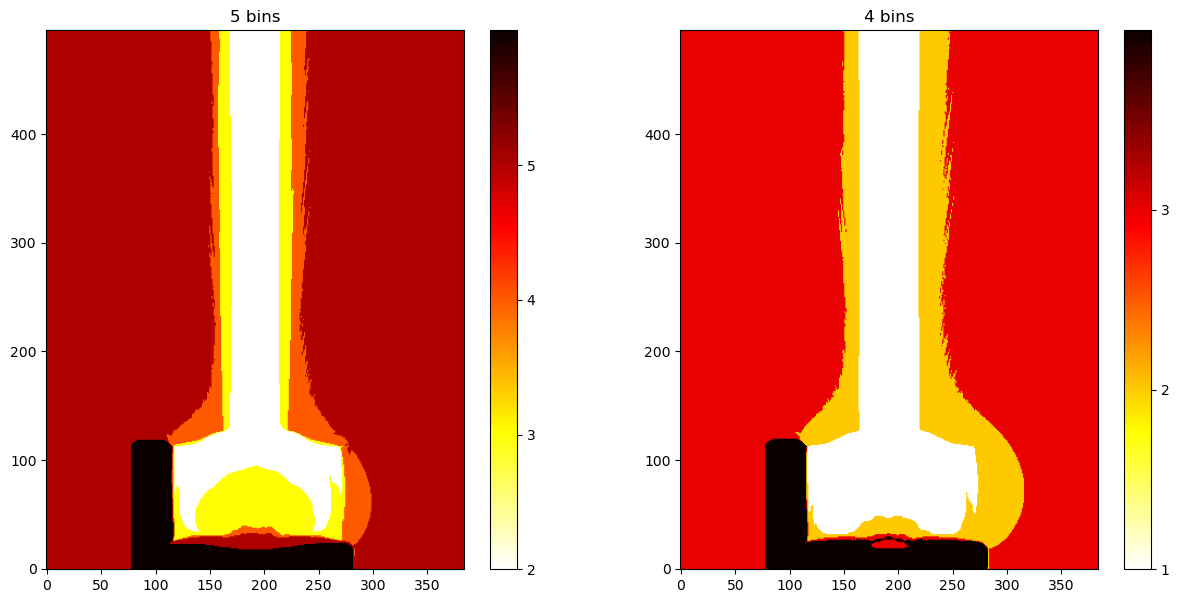

In [5]:
plt.figure(figsize=(15, 7))

Si14 = 28.084*1836.152673/14
Si13 = 28.084*1836.152673/13
Si12 = 28.084*1836.152673/12
Si11 = 28.084*1836.152673/11
Al13 = 26.9815385*1836.152673/13
Al12 = 26.9815385*1836.152673/12
Al11 = 26.9815385*1836.152673/11
Al10 = 26.9815385*1836.152673/10
Al9 = 26.9815385*1836.152673/9
Al8 = 26.9815385*1836.152673/8
Al7 = 26.9815385*1836.152673/7
Al6 = 26.9815385*1836.152673/6
print("Si14", Si14)
print("Si13", Si13)
print("Si12", Si12)
print("Si11", Si11)
print("Al13", Al13)
print("Al12", Al12)
print("Al11", Al11)
print("Al10", Al10)
print("Al9", Al9)
print("Al8", Al8)
print("Al7", Al7)
print("Al6", Al6)


thresholds = [3000,4000,6000,7000,10000]  # Define thresholds
bins = [-np.inf] + thresholds + [np.inf]
groups = np.digitize(rqm_real, bins)

plt.subplot(121)
plt.imshow(groups[:, :, np.shape(rqm_real)[2] // 2].T, cmap='hot_r', origin='lower')
plt.colorbar(ticks=range(len(thresholds)+1))
plt.title("5 bins")

thresholds = [4500,7100,8300]  # Define thresholds, after lots of trial and error, these seem to be best
# The idea is that the first bin should contain Si{14..12} and Al{13..11}
# Bin 2 Should contain Al{10..7} Sil{11}
# Bin 3 Should contain Al{6}
# Bin 4 Should the solid target and x-ray shield

bins = [-np.inf] + thresholds + [np.inf]
groups = np.digitize(rqm_real, bins)

plt.subplot(122)
plt.imshow(groups[:, :, np.shape(rqm_real)[2] // 2].T, cmap='hot_r', origin='lower')
plt.colorbar(ticks=range(len(thresholds)+1))
plt.title("4 bins")



Cool. Looks like starwars or some shit. It looks like there are some artifacts but nothing super bad. The solid density stuff should largely be ignored, so a good metric for what box to use in the future is probably just whatever doesn't include much of the solid.

Now let's try applying the mask to rqm_real and see what the various species that we picked out were

Text(0.5, 1.0, 'Background, avg. rqm: 7412           stddev: 200')

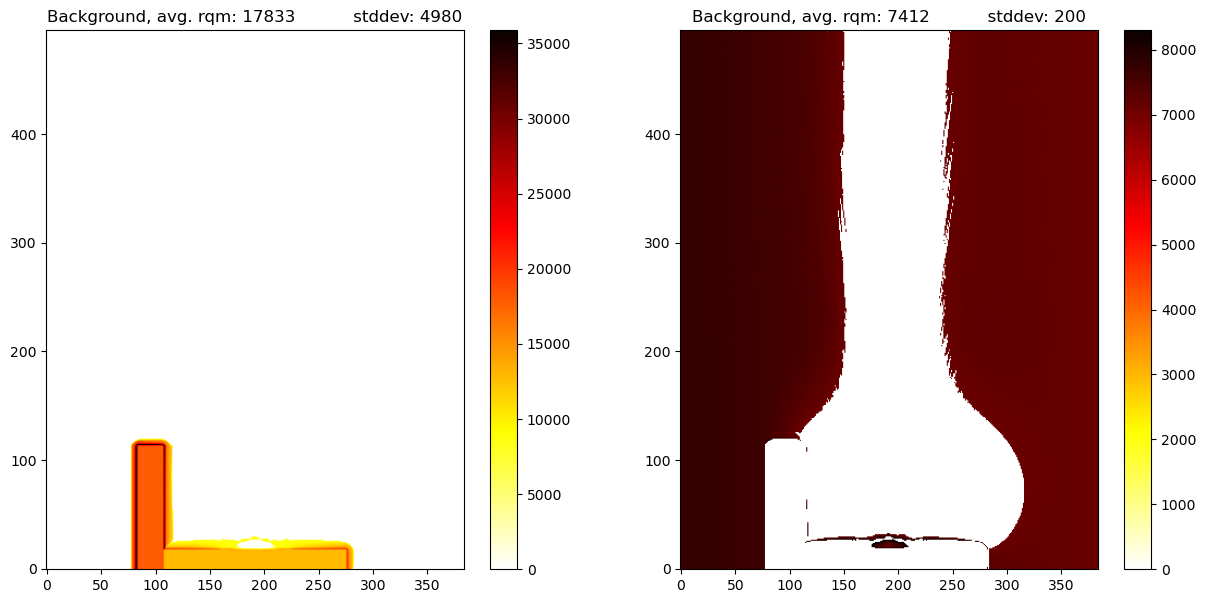

In [6]:
plt.figure(figsize=(15, 7))

# Create a mask for the background species
mask_background = (groups == 4)

# Apply the mask to rqm_real
spe_background = rqm_real * mask_background

# Plot the middle slice of the background species
plt.subplot(121)
plt.imshow(spe_background[:, :, np.shape(rqm_real)[2] // 2].T, cmap='hot_r', origin='lower')
plt.colorbar()
plt.title(f"Background, avg. rqm: {int(np.median(spe_background[mask_background].value))} \
          stddev: {int(np.std(spe_background[mask_background].value))}")


# Create a mask for the background species
mask_background = (groups == 3)

# Apply the mask to rqm_real
spe_background = rqm_real * mask_background

# Plot the middle slice of the background species
plt.subplot(122)
plt.imshow(spe_background[:, :, np.shape(rqm_real)[2] // 2].T, cmap='hot_r', origin='lower')
plt.colorbar()
plt.title(f"Background, avg. rqm: {int(np.median(spe_background[mask_background].value))} \
          stddev: {int(np.std(spe_background[mask_background].value))}")

Text(0.5, 1.0, 'Deep channel, average rqm is 3810           stddev: 247')

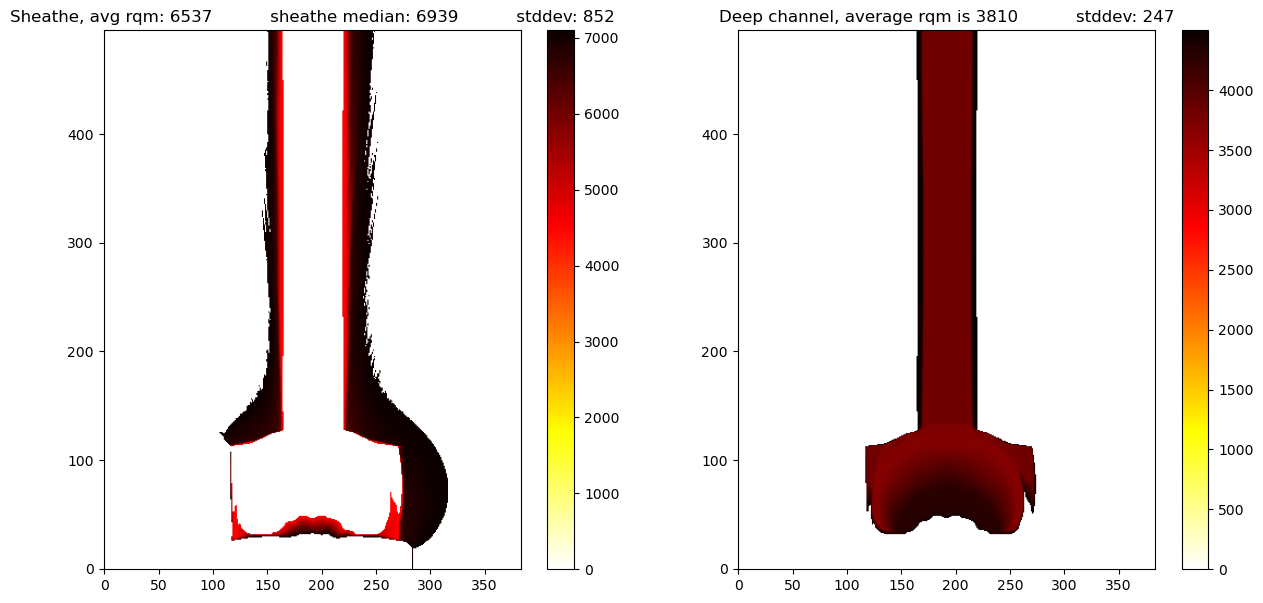

In [7]:
plt.figure(figsize=(15, 7))
# Create a mask for the background species
mask_background = (groups == 2)

# Apply the mask to rqm_real
spe_background = rqm_real * mask_background

# Plot the middle slice of the background species
plt.subplot(121)
plt.imshow(spe_background[:, :, np.shape(rqm_real)[2] // 2].T, cmap='hot_r', origin='lower')
plt.colorbar()
plt.title(f"Sheathe, avg rqm: {int(np.mean(spe_background[mask_background].value))} \
          sheathe median: {int(np.median(spe_background[mask_background].value))} \
          stddev: {int(np.std(spe_background[mask_background].value))}")

# Create a mask for the background species
mask_background = (groups == 1)

# Apply the mask to rqm_real
spe_background = rqm_real * mask_background

# Plot the middle slice of the background species
plt.subplot(122)
plt.imshow(spe_background[:, :, np.shape(rqm_real)[2] // 2].T, cmap='hot_r', origin='lower')
plt.colorbar()
plt.title(f"Deep channel, average rqm is {int(np.median(spe_background[mask_background].value))} \
          stddev: {int(np.std(spe_background[mask_background].value))}")

Not entirely sure where I should go from here. I could just pick a factor to divide all rqm by, such that the channel or the background has rqm==400? not sure honestly...

Let's not worry about normalization and go to the final step, defining the correct density profiles for OSIRIS. OSIRIS initializes **charge** density, so we only really need the electron number density. We do need to derive the electron density but it isn't too bad.

Text(0.5, 1.0, 'electron density normalized to n0 = 5e+18 with a lower colorbar limit')

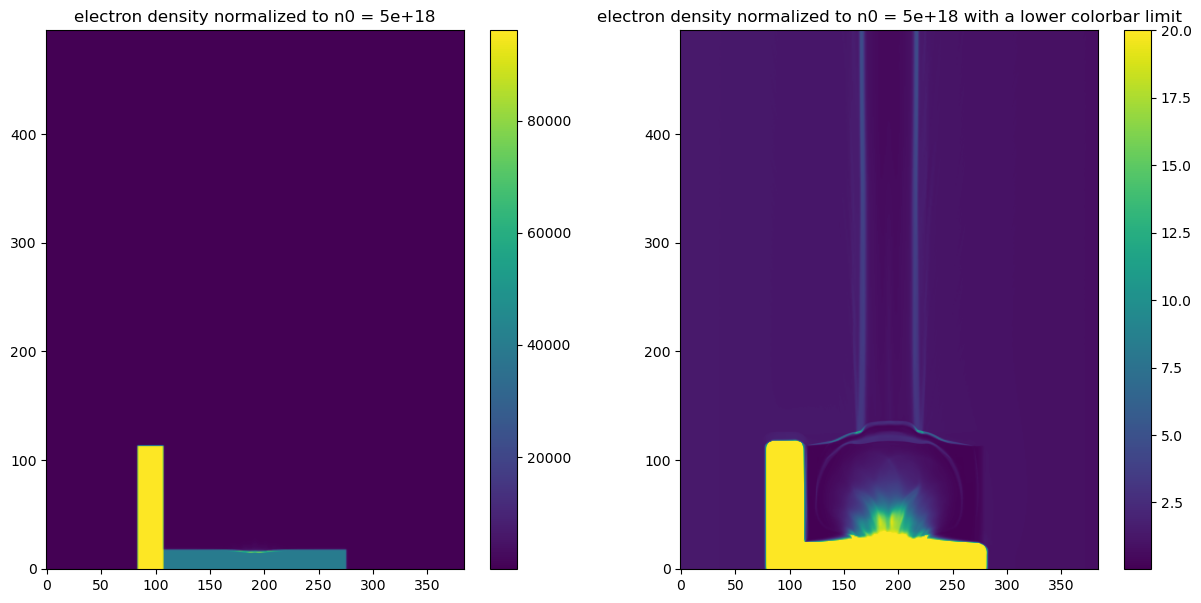

In [8]:
avogadro = 6.022e23
edens = avogadro * all_data["flash","ye"] * all_data['flash','dens']

n0 = 5e18


plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(edens[:, :, np.shape(edens)[2] // 2].T / n0, label = "Density", origin= 'lower')
plt.colorbar()
plt.title(f"electron density normalized to n0 = {n0}")

plt.subplot(122)
plt.imshow(edens[:, :, np.shape(edens)[2] // 2].T / n0, label = "Density", origin= 'lower',vmax = 20)
plt.colorbar()
plt.title(f"electron density normalized to n0 = {n0} with a lower colorbar limit")

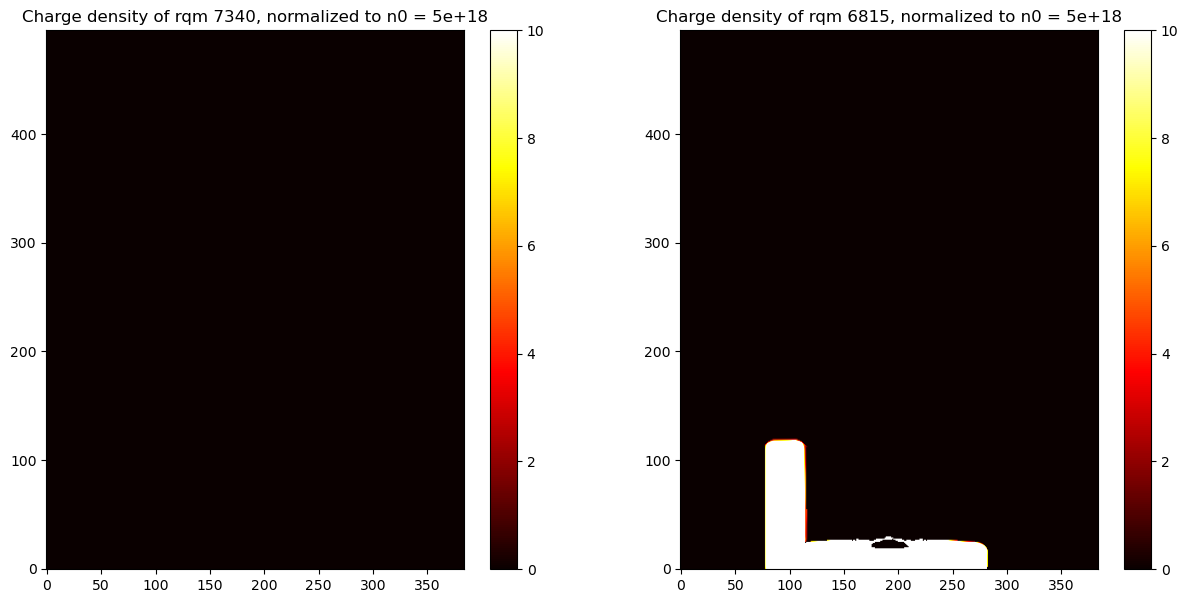

In [9]:
plt.figure(figsize=(15, 7))
rqm_7340_mask = (groups == 5)

density7340 = edens * rqm_7340_mask

plt.subplot(121)
plt.imshow(density7340[:, :, np.shape(density7340)[2] // 2].T/n0, cmap='hot', origin='lower',vmax = 10)
plt.colorbar()
plt.title(f"Charge density of rqm 7340, normalized to n0 = {n0}")


rqm_6815_mask = (groups == 4)
density6815 = edens * rqm_6815_mask

plt.subplot(122)
plt.imshow(density6815[:, :, np.shape(density6815)[2] // 2].T/n0, cmap='hot', origin='lower',vmax = 10)
plt.colorbar()
plt.title(f"Charge density of rqm 6815, normalized to n0 = {n0}")
plt.show()

Text(0.5, 1.0, 'Charge density of rqm 3802, normalized to n0 = 5e+18')

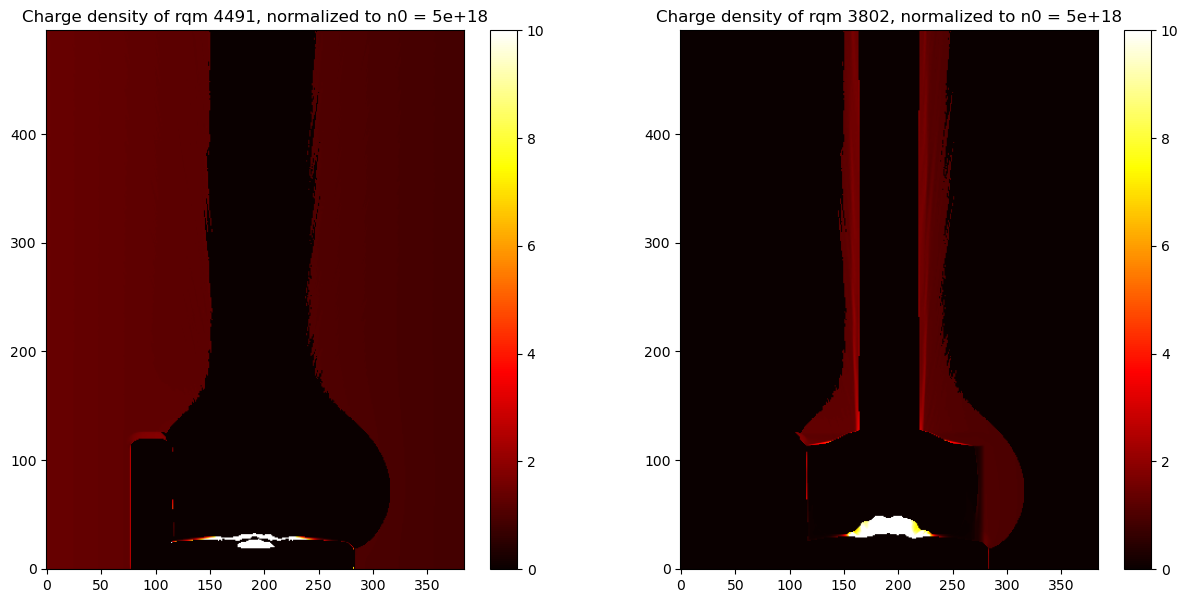

In [10]:
plt.figure(figsize=(15, 7))

rqm_4491_mask = (groups == 3)
density4491 = edens * rqm_4491_mask
plt.subplot(121)
plt.imshow(density4491[:, :, np.shape(density4491)[2] // 2].T/n0, cmap='hot', origin='lower',vmax = 10)
plt.colorbar()
plt.title(f"Charge density of rqm 4491, normalized to n0 = {n0}")

rqm_3802_mask = (groups == 2)
density3802 = edens * rqm_3802_mask
plt.subplot(122)
plt.imshow(density3802[:, :, np.shape(density3802)[2] // 2].T/n0, cmap='hot', origin='lower',vmax = 10)
plt.colorbar()
plt.title(f"Charge density of rqm 3802, normalized to n0 = {n0}")


Let's put it all together. Define the appropriate ion species, put a bunch of nans in for the solid target so you make sure that you don't initialize that sheesh

Text(0.5, 1.0, 'Aluminum channel, rqm of 3810 normalized to n0 = 5e+18')

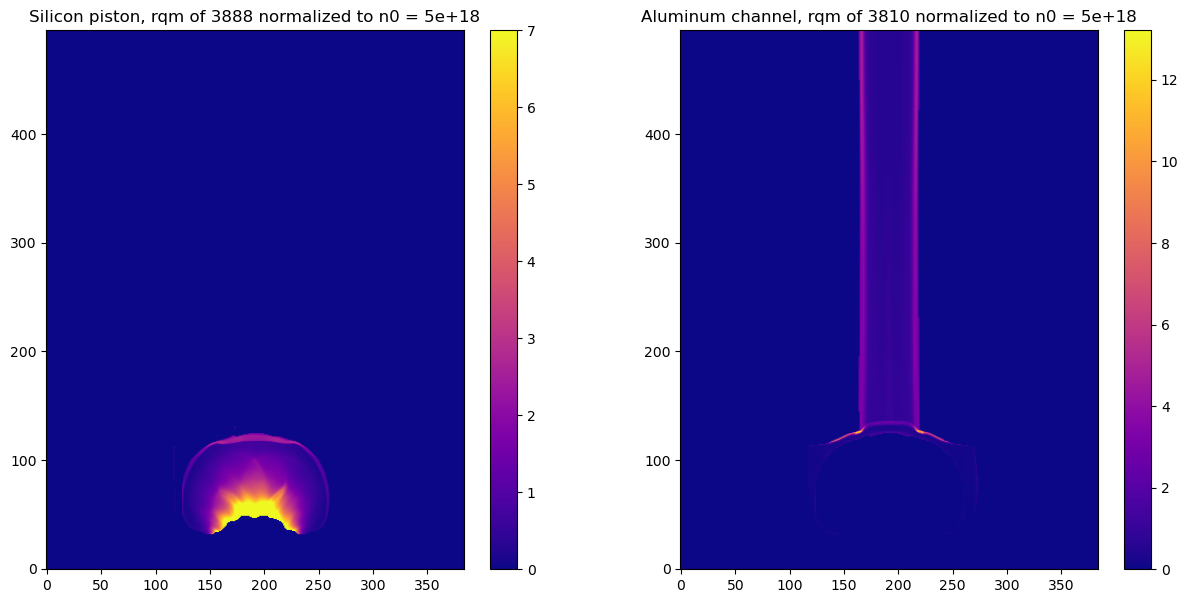

In [11]:
plt.figure(figsize=(15, 7))

full_mask = (groups == 1) * (species_mask == 2)

silicon_piston = edens * (groups == 1) * (species_mask == 2)

plt.subplot(121)
plt.imshow(silicon_piston[:, :, np.shape(silicon_piston)[2] // 2].T/n0, cmap='plasma', origin='lower',vmax = 7)
plt.colorbar()
plt.title(f"Silicon piston, rqm of {int(np.median(rqm_real[full_mask]))} normalized to n0 = {n0}")


full_mask = (groups == 1) * (species_mask == 1)

deep_channel = edens * (groups == 1) * (species_mask == 1)

plt.subplot(122)
plt.imshow(deep_channel[:, :, np.shape(deep_channel)[2] // 2].T/n0, cmap='plasma', origin='lower',)
plt.colorbar()
plt.title(f"Aluminum channel, rqm of {int(np.median(rqm_real[full_mask]))} normalized to n0 = {n0}")

Text(0.5, 1.0, 'Aluminum background, rqm of 7412 normalized to n0 = 5e+18')

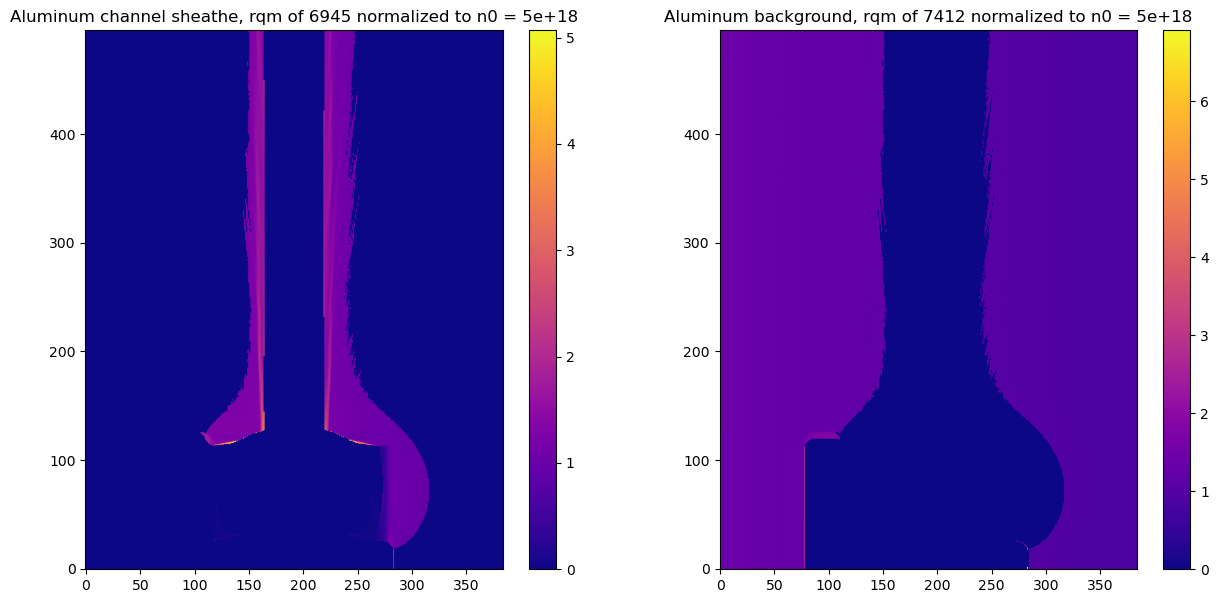

In [12]:
plt.figure(figsize=(15, 7))

full_mask = (groups == 2) * (species_mask == 1)

channel_sheathe = edens * (groups == 2) * (species_mask == 1)

plt.subplot(121)
plt.imshow(channel_sheathe[:, :, np.shape(channel_sheathe)[2] // 2].T/n0, cmap='plasma', origin='lower',)
plt.colorbar()
plt.title(f"Aluminum channel sheathe, rqm of {int(np.median(rqm_real[full_mask]))} normalized to n0 = {n0}")


full_mask = (groups == 3) * (species_mask == 1)

background = edens * (groups == 3) * (species_mask == 1)

plt.subplot(122)
plt.imshow(background[:, :, np.shape(background)[2] // 2].T/n0, cmap='plasma', origin='lower',)
plt.colorbar()
plt.title(f"Aluminum background, rqm of {int(np.median(rqm_real[full_mask]))} normalized to n0 = {n0}")

## It might be helpful to do this with the simpler simulation
Should only really need to define a couple species:
- Silicon
- Background
- Channel


In [18]:
data_path = "/mnt/cellar/shared/simulations/FLASH_MagShockZ3D-Trantham_06-2024/MAGON/MagShockZ_hdf5_chk_0005"
ds = yt.load_for_osiris(data_path, rqm_factor = 1)

level =2 
dims = ds.domain_dimensions * ds.refine_by**level
all_data = ds.covering_grid(
    level,
    left_edge=ds.domain_left_edge,
    dims=dims,
)

yt : [INFO     ] 2025-07-14 14:02:40,813 Parameters: current_time              = 1.8520020414484505e-09
yt : [INFO     ] 2025-07-14 14:02:40,813 Parameters: domain_dimensions         = [288 272 288]
yt : [INFO     ] 2025-07-14 14:02:40,813 Parameters: domain_left_edge          = [-0.6   -0.075 -0.6  ]
yt : [INFO     ] 2025-07-14 14:02:40,814 Parameters: domain_right_edge         = [0.6 1.  0.6]
yt : [INFO     ] 2025-07-14 14:02:40,814 Parameters: cosmological_simulation   = 0


Channel rqm: 1835


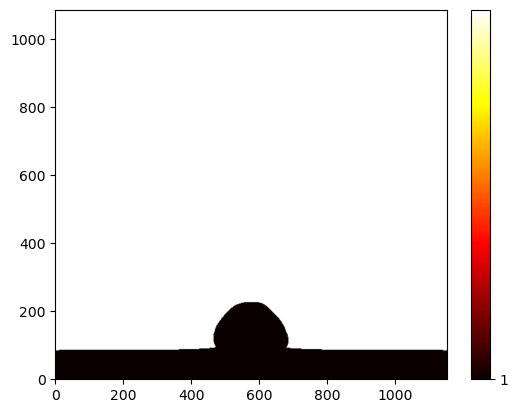

In [19]:
abar = 1/all_data["flash",'sumy']
zbar = all_data["flash",'ye']/all_data["flash","sumy"]
rqm_real = 1836/all_data["flash","ye"]

thresholds = [25.5]  # Define threshold to delineate one ion species from another
bins = [-np.inf] + thresholds + [np.inf]
species_mask = np.digitize(abar, bins)

plt.imshow(species_mask[:, :, np.shape(abar)[2] // 2].T, cmap='hot', origin='lower')
plt.colorbar(ticks=range(len(thresholds)+1))

Si14 3683.322262038
Si13 3966.654743733231
Si12 4297.2093057110005
Si11 4687.864697139273
Al13 3810.9403106482623
Al12 4128.518669868951
Al11 4503.838548947947
Al10 4954.222403842741
Al9 5504.691559825268
Al8 6192.7780048034265
Al7 7077.460576918202
Al6 8257.037339737903


Text(0.5, 1.0, '4 bins')

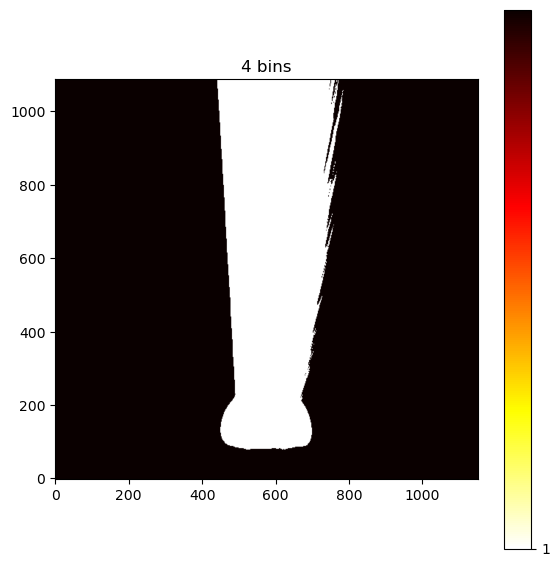

In [ ]:
plt.figure(figsize=(15, 7))

Si14 = 28.084*1836.152673/14
Si13 = 28.084*1836.152673/13
Si12 = 28.084*1836.152673/12
Si11 = 28.084*1836.152673/11
Al13 = 26.9815385*1836.152673/13
Al12 = 26.9815385*1836.152673/12
Al11 = 26.9815385*1836.152673/11
Al10 = 26.9815385*1836.152673/10
Al9 = 26.9815385*1836.152673/9
Al8 = 26.9815385*1836.152673/8
Al7 = 26.9815385*1836.152673/7
Al6 = 26.9815385*1836.152673/6
print("Si14", Si14)
print("Si13", Si13)
print("Si12", Si12)
print("Si11", Si11)
print("Al13", Al13)
print("Al12", Al12)
print("Al11", Al11)
print("Al10", Al10)
print("Al9", Al9)
print("Al8", Al8)
print("Al7", Al7)
print("Al6", Al6)


thresholds = [4500]  # Define thresholds 

bins = [-np.inf] + thresholds + [np.inf]
groups = np.digitize(rqm_real, bins)

plt.subplot(122)
plt.imshow(groups[:, :, np.shape(rqm_real)[2] // 2].T, cmap='hot_r', origin='lower')
plt.colorbar(ticks=range(len(thresholds)+1))
plt.title("4 bins")